![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

### Integrantes:
- Jesus Alberto Parada Perez
- Jorge Esteban Caballero
- Diana Villalba
- Juan Jose Ovalle

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv(
    "https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip",
    index_col=0,
)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets["airline_sentiment"].value_counts(True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets["airline"].value_counts(True)

United            0.261066
US Airways        0.198975
American          0.188456
Southwest         0.165301
Delta             0.151776
Virgin America    0.034426
Name: airline, dtype: float64

<AxesSubplot:title={'center':'Sentimientos por aerolínea'}, xlabel='airline'>

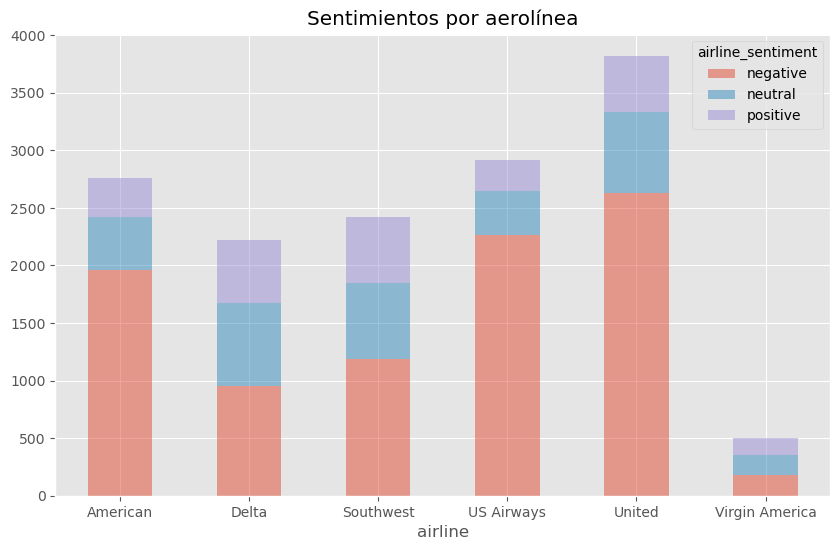

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index=tweets["airline"], columns=tweets["airline_sentiment"]).plot(
    kind="bar",
    figsize=(10, 6),
    alpha=0.5,
    rot=0,
    stacked=True,
    title="Sentimientos por aerolínea",
)

### Liberias y Variables de interés y predicción

In [8]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets["text"]
y = tweets["airline_sentiment"].map({"negative": -1, "neutral": 0, "positive": 1})

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

Reporte de clasificación para el set de Test:
              precision    recall  f1-score   support

          -1       0.77      0.96      0.86      3085
           0       0.70      0.40      0.51       984
           1       0.83      0.46      0.59       763

    accuracy                           0.77      4832
   macro avg       0.77      0.61      0.65      4832
weighted avg       0.77      0.77      0.75      4832



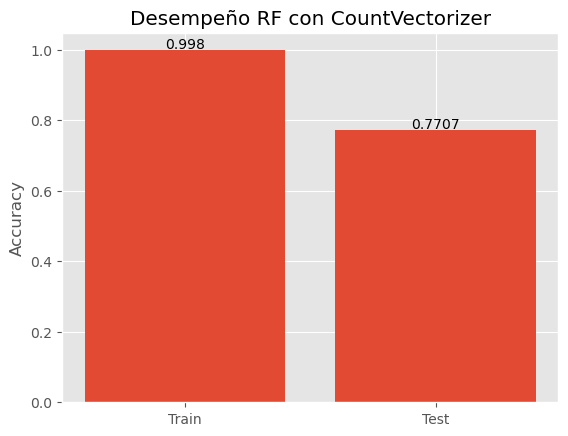

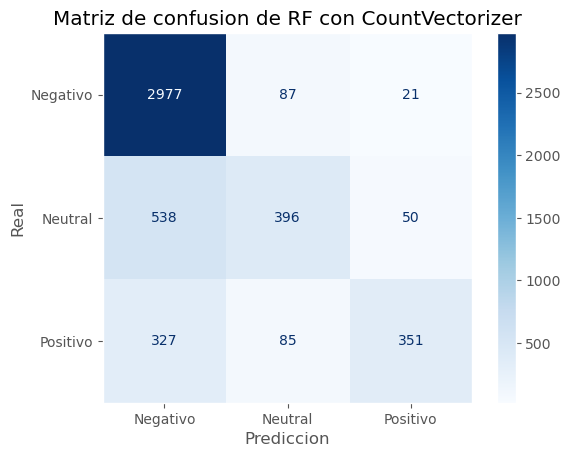

In [11]:
# Celda 1

# Se crea modelo RF
clf = RandomForestClassifier(n_jobs=-1, random_state=1399)

# Se transforman los datos usando CountVectorizer
vectorizer = CountVectorizer()
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

# Se entrena el modelo
clf.fit(X_train_v, y_train)

# Se obtienen metricas para train y test
y_train_pred = clf.predict(X_train_v)
y_test_pred = clf.predict(X_test_v)
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
report_test_1 = classification_report(y_true=y_test, y_pred=y_test_pred)

report_1 = pd.DataFrame(classification_report(y_true=y_test, 
                                              y_pred=y_test_pred,
                                              labels=np.unique(y_test),
                                              target_names=['Negativo', 'Neutral', 'Positivo'],
                                              output_dict=True)).iloc[:-2, :-3].T

# Se grafican los resultados del modelo
fig, ax = plt.subplots()

ax.bar(["Train", "Test"], [acc_train, acc_test])
for i, v in enumerate([acc_train, acc_test]):
    ax.text(i, v + 0.005, str(round(v, 4)), size=10, ha="center")
ax.set_title("Desempeño RF con CountVectorizer")
ax.set_ylabel("Accuracy")

# Se grafica la matriz de confusion
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=clf.predict(X_test_v),
    cmap="Blues",
    display_labels={"Negativo": -1, "Neutral": 0, "Positivo": 1},
)
plt.xlabel("Prediccion")
plt.ylabel("Real")
plt.title("Matriz de confusion de RF con CountVectorizer")
plt.grid(False)

# Se imprimen las metricas de precision, recall y f1-score
print("Reporte de clasificación para el set de Test:")
print(report_test_1)

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

Reporte de clasificación para el set de Test:
              precision    recall  f1-score   support

          -1       0.82      0.89      0.86      3085
           0       0.58      0.50      0.54       984
           1       0.73      0.60      0.66       763

    accuracy                           0.77      4832
   macro avg       0.71      0.67      0.68      4832
weighted avg       0.76      0.77      0.76      4832



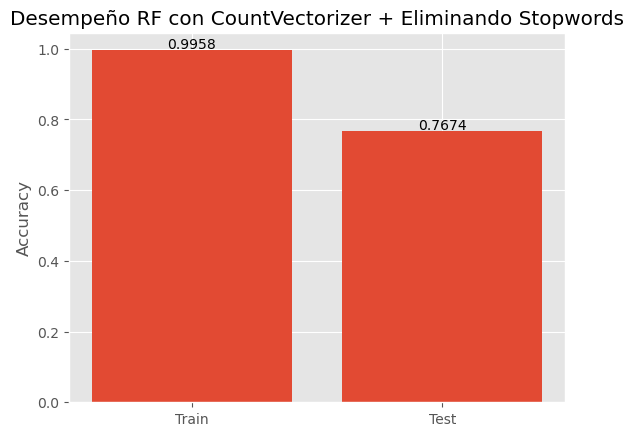

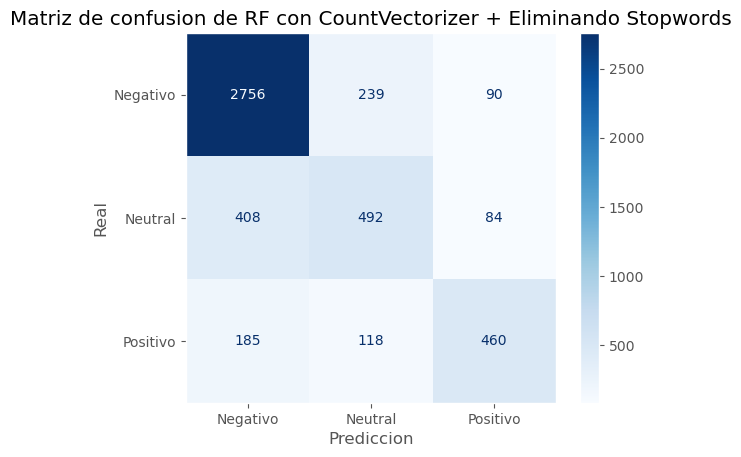

In [12]:
# Celda 2

# Se crea modelo RF
clf = RandomForestClassifier(n_jobs=-1, random_state=1399)

# Se transforman los datos usando CountVectorizer y eliminando stopwords
vectorizer = CountVectorizer(stop_words="english")
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

# Se entrena el modelo
clf.fit(X_train_v, y_train)

# Se obtienen metricas para train y test
y_train_pred = clf.predict(X_train_v)
y_test_pred = clf.predict(X_test_v)
acc_train_2 = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test_2 = accuracy_score(y_true=y_test, y_pred=y_test_pred)
report_test_2 = classification_report(y_true=y_test, y_pred=y_test_pred)

report_2 = pd.DataFrame(classification_report(y_true=y_test, 
                                              y_pred=y_test_pred,
                                              labels=np.unique(y_test),
                                              target_names=['Negativo', 'Neutral', 'Positivo'],
                                              output_dict=True)).iloc[:-2, :-3].T


# Se grafican los resultados del modelo
fig, ax = plt.subplots()

ax.bar(["Train", "Test"], [acc_train_2, acc_test_2])
for i, v in enumerate([acc_train_2, acc_test_2]):
    ax.text(i, v + 0.005, str(round(v, 4)), size=10, ha="center")
ax.set_title("Desempeño RF con CountVectorizer + Eliminando Stopwords")
ax.set_ylabel("Accuracy")

# Se grafica la matriz de confusion
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=clf.predict(X_test_v),
    cmap="Blues",
    display_labels={"Negativo": -1, "Neutral": 0, "Positivo": 1},
)
plt.xlabel("Prediccion")
plt.ylabel("Real")
plt.title("Matriz de confusion de RF con CountVectorizer + Eliminando Stopwords")
plt.grid(False)

# Se imprimen las metricas de precision, recall y f1-score
print("Reporte de clasificación para el set de Test:")
print(report_test_2)

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Reporte de clasificación para el set de Test:
              precision    recall  f1-score   support

          -1       0.77      0.96      0.86      3085
           0       0.71      0.42      0.52       984
           1       0.84      0.45      0.59       763

    accuracy                           0.77      4832
   macro avg       0.78      0.61      0.66      4832
weighted avg       0.77      0.77      0.75      4832



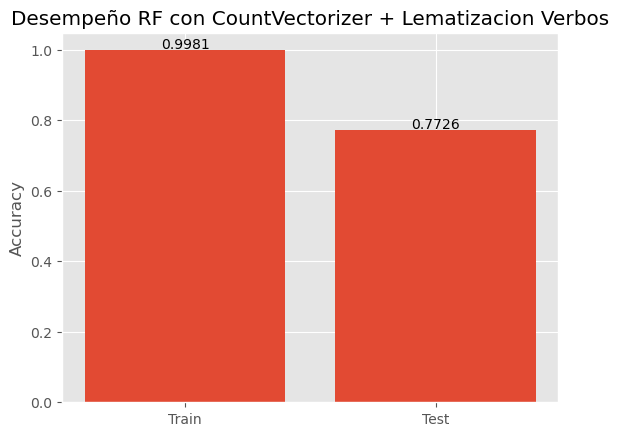

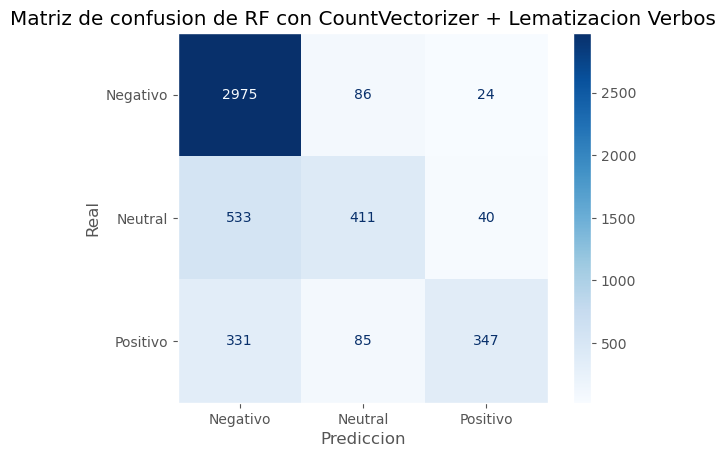

In [14]:
# Celda 3

# Se crea modelo RF
clf = RandomForestClassifier(n_jobs=-1, random_state=1399)

# Se lematiza el texto con verbos
def lemmatize_text(text):
    """Funcion auxiliar para lematizar con verbos `pos='v'`"""
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos="v") for token in tokens]
    return " ".join(lemmatized_tokens)


X_train_lem = X_train.copy().apply(lemmatize_text)
X_test_lem = X_test.copy().apply(lemmatize_text)

# Se transforman los datos usando CountVectorizer
vectorizer = CountVectorizer()
X_train_v = vectorizer.fit_transform(X_train_lem)
X_test_v = vectorizer.transform(X_test_lem)

# Se entrena el modelo
clf.fit(X_train_v, y_train)

# Se obtienen metricas para train y test
y_train_pred = clf.predict(X_train_v)
y_test_pred = clf.predict(X_test_v)
acc_train_3 = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test_3 = accuracy_score(y_true=y_test, y_pred=y_test_pred)
report_test_3 = classification_report(y_true=y_test, y_pred=y_test_pred)

report_3 = pd.DataFrame(classification_report(y_true=y_test, 
                                              y_pred=y_test_pred,
                                              labels=np.unique(y_test),
                                              target_names=['Negativo', 'Neutral', 'Positivo'],
                                              output_dict=True)).iloc[:-2, :-3].T

# Se grafican los resultados del modelo
fig, ax = plt.subplots()

ax.bar(["Train", "Test"], [acc_train_3, acc_test_3])
for i, v in enumerate([acc_train_3, acc_test_3]):
    ax.text(i, v + 0.005, str(round(v, 4)), size=10, ha="center")
ax.set_title("Desempeño RF con CountVectorizer + Lematizacion Verbos")
ax.set_ylabel("Accuracy")

# Se grafica la matriz de confusion
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=clf.predict(X_test_v),
    cmap="Blues",
    display_labels={"Negativo": -1, "Neutral": 0, "Positivo": 1},
)
plt.xlabel("Prediccion")
plt.ylabel("Real")
plt.title("Matriz de confusion de RF con CountVectorizer + Lematizacion Verbos")
plt.grid(False)

# Se imprimen las metricas de precision, recall y f1-score
print("Reporte de clasificación para el set de Test:")
print(report_test_3)

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

Reporte de clasificación para el set de Test:
              precision    recall  f1-score   support

          -1       0.82      0.89      0.85      3085
           0       0.58      0.49      0.53       984
           1       0.71      0.59      0.64       763

    accuracy                           0.76      4832
   macro avg       0.70      0.66      0.67      4832
weighted avg       0.75      0.76      0.75      4832



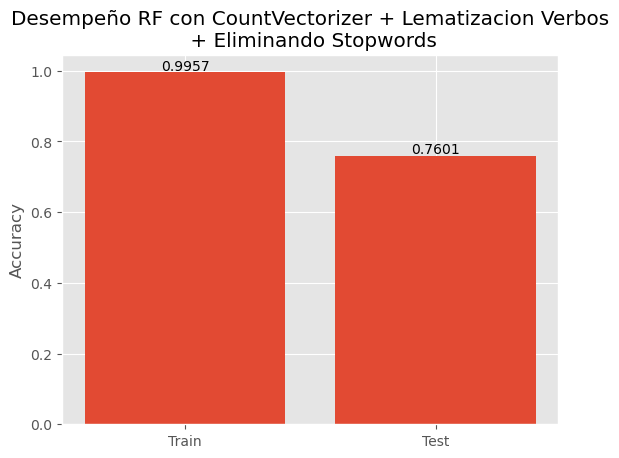

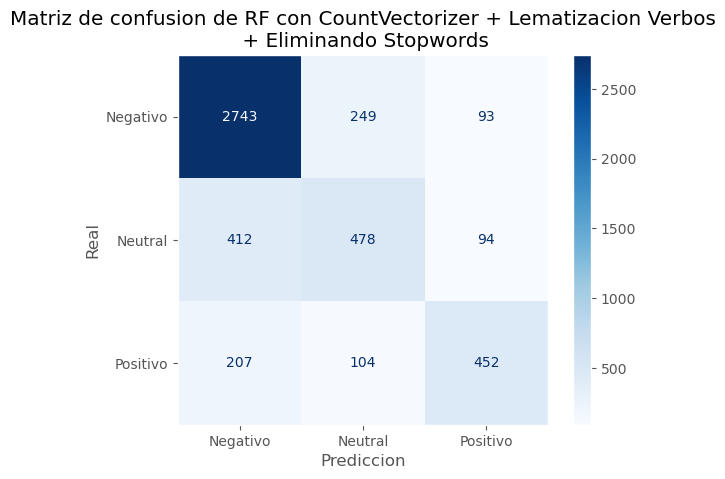

In [15]:
# Celda 4

# Se crea modelo RF
clf = RandomForestClassifier(n_jobs=-1, random_state=1399)

# Se lematiza el texto con verbos
X_train_lem = X_train.copy().apply(lemmatize_text)
X_test_lem = X_test.copy().apply(lemmatize_text)

# Se transforman los datos usando CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
X_train_v = vectorizer.fit_transform(X_train_lem)
X_test_v = vectorizer.transform(X_test_lem)

# Se entrena el modelo
clf.fit(X_train_v, y_train)

# Se obtienen metricas para train y test
y_train_pred = clf.predict(X_train_v)
y_test_pred = clf.predict(X_test_v)
acc_train_4 = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test_4 = accuracy_score(y_true=y_test, y_pred=y_test_pred)
report_test_4 = classification_report(y_true=y_test, y_pred=y_test_pred)

report_4 = pd.DataFrame(classification_report(y_true=y_test, 
                                              y_pred=y_test_pred,
                                              labels=np.unique(y_test),
                                              target_names=['Negativo', 'Neutral', 'Positivo'],
                                              output_dict=True)).iloc[:-2, :-3].T

# Se grafican los resultados del modelo
fig, ax = plt.subplots()

ax.bar(["Train", "Test"], [acc_train_4, acc_test_4])
for i, v in enumerate([acc_train_4, acc_test_4]):
    ax.text(i, v + 0.005, str(round(v, 4)), size=10, ha="center")
ax.set_title(
    "Desempeño RF con CountVectorizer + Lematizacion Verbos\n + Eliminando Stopwords"
)
ax.set_ylabel("Accuracy")

# Se grafica la matriz de confusion
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=clf.predict(X_test_v),
    cmap="Blues",
    display_labels={"Negativo": -1, "Neutral": 0, "Positivo": 1},
)
plt.xlabel("Prediccion")
plt.ylabel("Real")
plt.title(
    "Matriz de confusion de RF con CountVectorizer + Lematizacion Verbos\n + Eliminando Stopwords"
)
plt.grid(False)

# Se imprimen las metricas de precision, recall y f1-score
print("Reporte de clasificación para el set de Test:")
print(report_test_4)

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

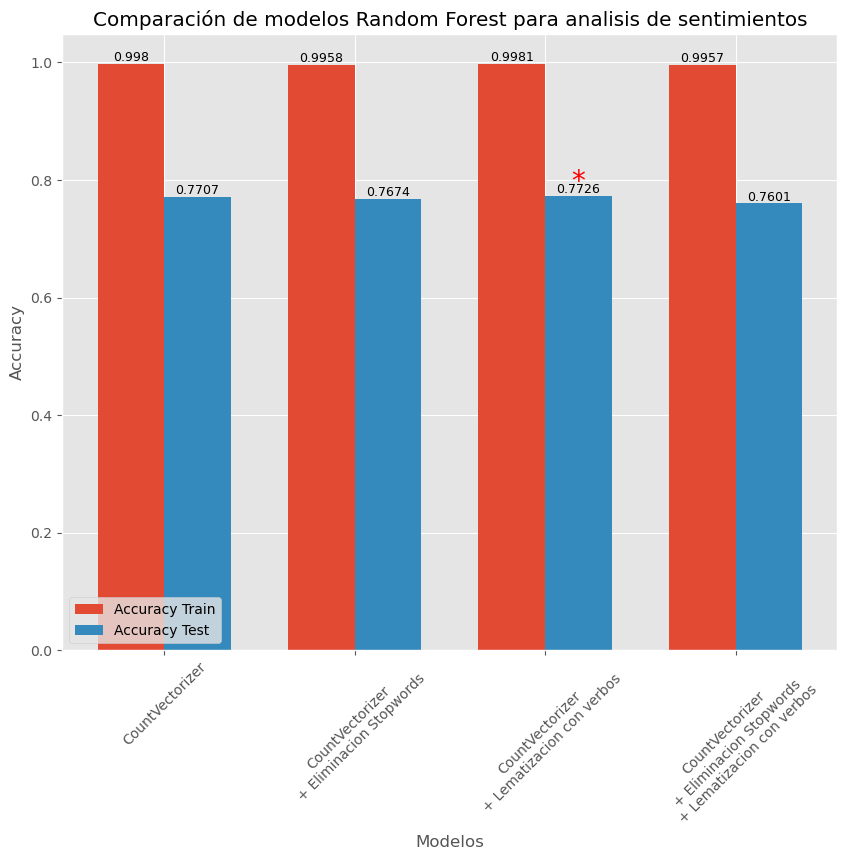

In [16]:
# Celda 5

# Etiquetas de modelos
modelos = [
    "CountVectorizer",
    "CountVectorizer\n + Eliminacion Stopwords",
    "CountVectorizer\n + Lematizacion con verbos",
    "CountVectorizer\n + Eliminacion Stopwords\n + Lematizacion con verbos",
]

# Accuracy de modelos
acc_train_list = [
    round(acc_train, 4),
    round(acc_train_2, 4),
    round(acc_train_3, 4),
    round(acc_train_4, 4),
]
acc_test_list = [
    round(acc_test, 4),
    round(acc_test_2, 4),
    round(acc_test_3, 4),
    round(acc_test_4, 4),
]

max_acc_test_index = np.argmax(acc_test_list)

# Graficar modelos
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.35
x = np.arange(len(modelos))
ax.bar(x - width / 2, acc_train_list, width=width, label="Accuracy Train")
ax.bar(x + width / 2, acc_test_list, width=width, label="Accuracy Test")

for i, _ in enumerate(acc_train_list):
    ax.text(
        i - width / 2,
        acc_train_list[i] + 0.005,
        str(acc_train_list[i]),
        size=9,
        ha="center",
    )
    ax.text(
        i + width / 2,
        acc_test_list[i] + 0.005,
        str(acc_test_list[i]),
        size=9,
        ha="center",
    )

ax.text(
    max_acc_test_index + width / 2,
    max(acc_test_list) + 0.01,
    "*",
    size=20,
    ha="center",
    color="red",
)
ax.set_xlabel("Modelos")
ax.set_ylabel("Accuracy")
ax.set_title("Comparación de modelos Random Forest para analisis de sentimientos")
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=45)
ax.legend(loc="lower left")
plt.show()

El mejor modelo en términos de accuracy en el conjunto de prueba es el que utiliza `CountVectorizer` y lematización con verbos con un accuracy de 0.7726:

- La lematización con verbos ayuda a reducir la dimensionalidad de los datos al agrupar palabras similares y, por lo tanto, mejora la eficacia del modelo.
- El modelo es capaz de captar mejor el significado y la intención detrás de los textos al tener en cuenta las formas básicas de los verbos.


El modelo con el peor desempeño en términos de accuracy en el conjunto de prueba es el que utiliza `CountVectorizer`, eliminación de Stopwords y lematización con verbos, con un accuracy de 0.7601:

- A pesar de que se eliminaron las palabras vacías (stopwords) y se lematizaron los verbos, la combinación de estas técnicas no ha mejorado el rendimiento del modelo. Es posible que eliminar las palabras vacías haya quitado cierto contexto de los datos, lo que ha afectado el rendimiento del modelo.

- La eliminación de las palabras vacías puede simplificar el texto y reducir la dimensionalidad, pero también puede eliminar información útil que puede ser relevante para el análisis de sentimientos en algunos casos.


Es importante destacar que, al observar la matriz de confusión, se puede apreciar que los modelos correspondientes al punto 4 y al punto 2 tienen un mejor rendimiento en las clases Positivo y Negativo que los demás modelos. Si se tiene interés en alguna de estas categorías, se recomienda utilizar alguno de estos modelos. Por ejemplo, si se desea identificar con certeza los mensajes negativos para brindar ayuda psicológica.

Los modelos tienden a confundir Neutral y Negativo, ya que sus falsos positivos y falsos negativos son similares en magnitud a sus verdaderos positivos y negativos. Para mejorar el rendimiento del modelo, se puede considerar cambiar el problema de clasificación a 1vAll de Positivo vs. Neutro o Negativo.

In [17]:
# Define los nombres de los modelos y los dataframes con los resultados de precisión y recall
modelos = [
    "CountVectorizer",
    "CountVectorizer\n + Eliminacion Stopwords",
    "CountVectorizer\n + Lematizacion con verbos",
    "CountVectorizer\n + Eliminacion Stopwords\n + Lematizacion con verbos",
]
dataframes = [report_1, report_2, report_3, report_4]

# Agrega el nombre del modelo a cada dataframe y resetea los indices
for i, modelo in enumerate(modelos):
    dataframes[i]['Modelo'] = modelo
    dataframes[i].reset_index(inplace=True)
    dataframes[i].rename(columns={'index': 'Clases'}, inplace=True)

# Concatena los dataframes en uno solo
df = pd.concat(dataframes, ignore_index=True)

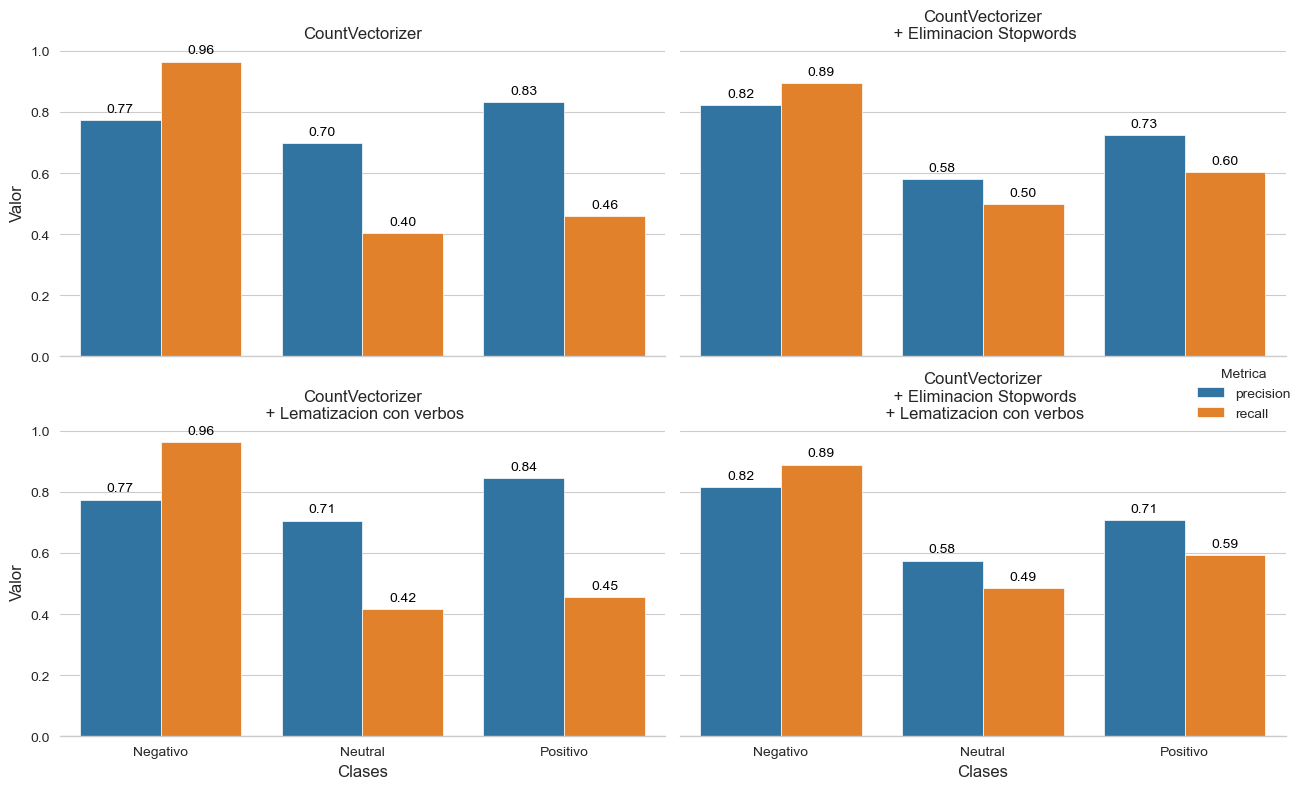

In [18]:
# Define los colores para cada valor (precisión y recall)
colors = ['tab:blue', 'tab:orange']

# Grafica los resultados de precisión y recall para cada modelo
sns.set_style("whitegrid")
g = sns.catplot(x='Clases', y='value', hue='Metrica', hue_order=['precision', 'recall'], palette=colors,
                col='Modelo', data=pd.melt(df, id_vars=['Modelo', 'Clases'], var_name='Metrica', value_name='value'),
                kind='bar', col_wrap=2, height=4, aspect=1.5, ci=None)

g.set_titles("{col_name}")
g.set_xlabels("Clases")
g.set_ylabels("Valor")
g.despine(left=True)

# Agregar etiquetas de valores a cada barra
for ax in g.axes.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


Teniendo en cuenta que:
- Precision: De todos los que el modelo clasificó como positivos, ¿qué proporción son realmente positivos?
- Recall: De todos los realmente positivos, ¿qué proporción clasificó el modelo como positivos?

1. Para la clase Negativo, el modelo con mejor precisión es CountVectorizer con eliminación de stopwords con un valor de 0.822932, lo cual indica que de todos los mensajes clasificados como negativos por el modelo, un 82.29% realmente son negativos. Por otro lado, el modelo con mejor recall es CountVectorizer con un valor de 0.964992, lo cual indica que de todos los mensajes realmente negativos, el modelo clasificó correctamente el 96.49%. El modelo CountVectorizer con eliminación de stopwords y el modelo CountVectorizer con lematización con verbos también presentan buenos resultados tanto en precisión como en recall para la clase Negativo, con valores de 0.815883 y 0.889141 para la precisión y el recall, respectivamente. En resumen, si se busca un modelo que tenga un buen equilibrio entre precisión y recall, se podría considerar el modelo CountVectorizer con eliminación de stopwords o el modelo CountVectorizer con lematización con verbos para la clase Negativo.

2. Para la clase Neutral, el modelo con mejor precisión es CountVectorizer\n + Lematizacion con verbos con un valor de 0.706186, seguido de CountVectorizer con un valor de 0.697183. Mientras que el modelo con mejor recall es CountVectorizer\n + Eliminacion Stopwords con un valor de 0.500000, seguido de CountVectorizer\n + Eliminacion Stopwords\n + Lematizacion con verbos con un valor de 0.485772. Es importante tener en cuenta que en general, los modelos presentan un bajo desempeño en la clasificación de la clase Neutral.

3. Para la clase Positivo, el modelo con mejor precisión es CountVectorizer\n + Lematizacion con verbos con un valor de 0.844282, seguido de CountVectorizer con un valor de 0.831754. Sin embargo, el modelo con mejor recall es CountVectorizer\n + Eliminacion Stopwords con un valor de 0.602883, seguido de CountVectorizer\n + Eliminacion Stopwords\n + Lematizacion con verbos con un valor de 0.592398.

La elección del mejor modelo depende de los objetivos y prioridades del negocio. Si el enfoque está en maximizar la precisión en la clasificación de mensajes, entonces el modelo que utiliza CountVectorizer y lematización con verbos es el más adecuado para la clase neutral y positiva. Para la clase negativa, el modelo que utiliza CountVectorizer y eliminación de stopwords tiene la mejor precisión.

Por otro lado, si el objetivo es maximizar el recall, el modelo que utiliza CountVectorizer con eliminación de stopwords es el mejor para la clase neutral y positiva, mientras que para la clase negativa, el modelo que utiliza CountVectorizer tiene el mejor recall.

En resumen, si el negocio está buscando un equilibrio entre precisión y recall, se pueden utilizar modelos que combinan diferentes técnicas de preprocesamiento de texto y vectorización, como CountVectorizer con eliminación de stopwords y lematización con verbos, para obtener un mejor desempeño general en la clasificación de mensajes.